# 1.1 Two Body Trajectory
Students: Gabriel Wolf and Jakob Scheiber (Gruppe TU2)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt b: Data importieren und Matrix constructen

In [40]:

# Zuerst machen wir mal eine Matrix die eine Ellipse beschreibt, folgt aus Aufgabe a) 
def design_matrix(theta):
    return np.column_stack((np.ones_like(theta), np.cos(theta), np.sin(theta)))

# Dann stöpseln wir die Parameter der Ellipse mit der Gewichtung zusammen - Beta wird erst später im Code bestimmt
def inv_r(theta,beta):
    X = design_matrix(theta)
    return X @ beta

# Data Importieren, t ist Zeit und r ist Radius
#Zusätzlich noch die definition von T und t0
data =np.loadtxt("Data/Moon-Earth_distance.txt", skiprows=1 )
t=data[:,0]
r= data[:,1]

T= 27.55   #Periode -Tage- anomalistischer Monat
t0 = 1.71    # Zeitpunkt des ersten perigees- Tage

# Jetzt machen wir aus der Zeit aus dem .txt file nen Winkel
theta = 2 * np.pi * (t - t0) / T

# kurzer Test 
X= design_matrix(theta)
print(X.shape)    # (n,3) n = Anzahl der Datenpunkte, san in usnerem fall halt 200 data points

(200, 3)


### Unterpunkt c: Gram Schmidt QR decomposition

In [41]:
#Decomposen der Matrix A in eine orthogonale Matrix Q und eine obere Dreiecksmatrix R
#Das ganze mit einem modifizierten Gram-Schmidt Verfahren
#Input: Matrix A, Output: Matrizen Q und R

def gramschmidt_qr(A):
    #Vorerst mal zu einem numpy array konvertieren und größe definieren
    A =np.asarray(A, dtype=float);  m, n = A.shape
    Q =np.zeros((m, n))
    R =np.zeros((n, n))
    #Kopie von A damits nicht zerstört wird
    V =A.copy()
    R[0,0] = np.linalg.norm(V[:,0])  #ohne das bleibt r00 0 und es gibt nen offenen spot
    Q[:,0] = V[:,0] / R[0,0]
    for i in range(1, n):
        #In dieser Schleife wird die Orthogonalisierung gmacht
        for j in range(i):
            #In dieser Schleife werden die vorherigen Q Vektoren abgezogen
            R[j,i] =V[:,i]@Q[:,j]
            V[:,i] = V[:,i] - R[j,i] * Q[:,j]
        R[i,i] = np.linalg.norm(V[:,i])
        Q[:,i] = V[:,i] / R[i,i]
    return Q, R

Q,R= gramschmidt_qr(X)

#Test obs hinhaut
if np.allclose(X, Q @ R):
    print("pfeift 1")
else:
    print("nö 1")
    
if np.allclose(Q.T @ Q, np.eye(Q.shape[1])):
    print("pfeift 2")
else: 
    print("nö 2")
#Vewende bei beiden allclose weil der numerische Fehler ignoriert wird

print("Größe X:", X.shape)
print("Größe R:", R.shape)
print("Größe Q:", Q.shape)

pfeift 1
pfeift 2
Größe X: (200, 3)
Größe R: (3, 3)
Größe Q: (200, 3)


### Unterpunkt e: Berechnen des Schätzers Beta_dach

In [42]:
#erster Step: bestimme Q^T * y
QTy = Q.T @ (1/r)
print("Größe QTy:", QTy.shape)

#zweiter Step: löse R * beta = Q^T * y mit Rücksub
def backsub(R, b):
    n = R.shape[0]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):   # von unten nach oben
        x[i] = (b[i] - (R[i, i+1:]@x[i+1:]))/ R[i, i]
    return x

beta_hut = backsub(R, QTy)

print("BetaHütchen =", beta_hut) # sollte drei Zahlen, also B1,^B2,^B3 ausspucken
print("BetaHütchen Größe:", beta_hut.shape)
b0, b1, b2 = beta_hut
#Jetzt e und a ausrechnen, herleitung formel siehe COMP UE NOTES
e = np.sqrt(b1**2 + b2**2)/ b0
a = (1 + e**2) / (b0 * (1 - e**2))

print(f"Exzentrizität e = {e:.6f}")
print(f"Größe Hablachse a = {a:.6f} km") # hier die ergebnisse gerundet auf 6 KS



Größe QTy: (3,)
BetaHütchen = [2.60061828e-06 1.31269112e-07 8.75174466e-09]
BetaHütchen Größe: (3,)
Exzentrizität e = 0.050588
Größe Hablachse a = 386497.113106 km


### Unterpunkt f: Plotting

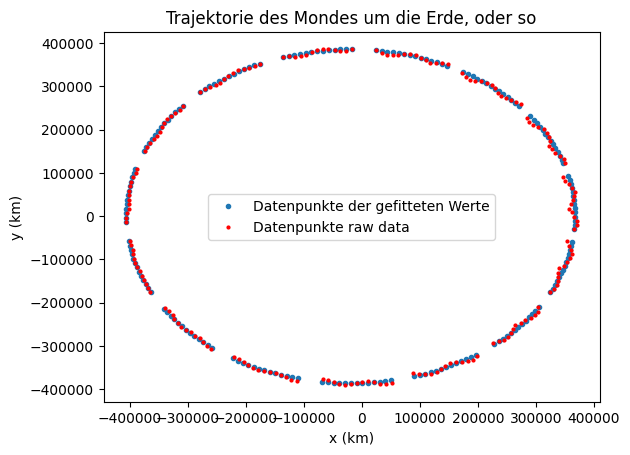

In [43]:
#Plotten der Trajektorie in der (x,y) ebene mit den gefitteten Werten
r_theta = a * (1 - e**2) / (1 + e * np.cos(theta)) # Formel für r(θ) aus der Aufgabenstellung
x =r_theta* np.cos(theta)
y=r_theta * np.sin(theta)
#Einfach für nen schönen vergleich die raw data auch plotten
x2 = r* np.cos(theta)
y2 = r* np.sin(theta)
plt.plot(x,y, 'o', label='Datenpunkte der gefitteten Werte', markersize=3)
plt.plot(x2,y2, 'o', label='Datenpunkte raw data', markersize=2, color='red')
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Trajektorie des Mondes um die Erde, oder so')
plt.legend()